# Feature engineering

* Feature selection
* Feature transformation

In [74]:
import pandas as pd

In [75]:
df = pd.read_csv('../input/cleaned_data.csv')

df

,building_id,building_type,primary_property_type,property_name,neighborhood,list_of_all_property_use_types,largest_property_use_type,second_largest_property_use_type,default_data,compliance_status,...,steam_use,electricity_kwh,electricity,natural_gas_therms,natural_gas,emissions_target,emissions_intensity,is_agregation,coords,distance_to_center
0,23163,NonResidential,Medical Office,LESCHI CENTER,downtown,Medical Office,Medical Office,NaN,Yes,Compliant,...,0.000,5.272270e+05,1.798974e+06,0.000000,0.000000e+00,12.540,0.110,False,"(47.59703102, -122.3168033)",1.51
1,23848,NonResidential,Restaurant\n,SPAGHETTI FACTORY,downtown,"Office, Restaurant",Restaurant,Office,No,Compliant,...,0.000,5.316360e+05,1.814019e+06,20028.000000,2.002751e+06,119.010,2.760,False,"(47.61522339, -122.354154)",1.95
2,21471,NonResidential,Other,EITEL BUILDING (2ND AND PIKE BUILDING),downtown,"Other, Personal Services (Health/Beauty, Dry C...",Other,Retail Store,No,Compliant,...,0.000,1.115070e+05,3.804780e+05,335.000000,3.345700e+04,4.430,0.060,False,"(47.60940552, -122.33934021)",0.67
3,21237,NonResidential,Retail Store,STAPLES,northwest,"Parking, Retail Store",Retail Store,Parking,Yes,Compliant,...,0.000,2.466200e+05,8.415010e+05,5507.000000,5.506860e+05,35.110,1.330,False,"(47.72569066, -122.3432661)",13.34
4,22138,NonResidential,Worship Facility,BRIGHTON PRESBYTERIAN CHURCH,southeast,NaN,NaN,NaN,No,Compliant,...,0.000,2.696300e+04,9.200000e+04,0.000000,0.000000e+00,0.640,0.010,False,"(47.54179702, -122.2703046)",8.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572,775,NonResidential,Large Office,Columbia Center - 2015,downtown,"Office, Parking",Office,Parking,False,Compliant,...,0.000,2.617277e+07,8.930337e+07,44473.816405,4.447364e+06,858.760,0.340,True,"(47.60454, -122.33072)",0.19
1573,753,NonResidential,Other,WestinBuilding,downtown,"Data Center, Office",Data Center,Office,False,Compliant,...,0.000,8.195296e+07,2.796294e+08,1511.360107,1.511555e+05,1957.390,3.135,True,"(47.61438, -122.33871)",1.06
1574,752,NonResidential,Large Office,ACTIVE VOICE,downtown,"Bar/Nightclub, Office, Personal Services (Heal...",Office,Bar/Nightclub,False,Compliant,...,2806907.625,1.945288e+06,6.637447e+06,13514.160155,1.351432e+06,334.705,1.905,True,"(47.61481, -122.33969)",1.14
1575,857,NonResidential,Warehouse,3480 W Marginal Way SW,southwest,"Non-Refrigerated Warehouse, Office",Non-Refrigerated Warehouse,Office,False,Compliant,...,0.000,2.852932e+05,9.734410e+05,1833.715027,1.833580e+05,16.525,0.095,True,"(47.57311, -122.3601)",4.22


## Correlation between the features

We must remove variables that are too much correlated to our targets :

* `emissions_target`
* `site_energy_use_target`

In [76]:
corr = df.corr()
corr.style.background_gradient(cmap='RdBu', vmin = -1, vmax = 1)

TARGET = 'emissions_target'

### Feature creation and engineering

In [77]:
df.head()

,building_id,building_type,primary_property_type,property_name,neighborhood,list_of_all_property_use_types,largest_property_use_type,second_largest_property_use_type,default_data,compliance_status,...,steam_use,electricity_kwh,electricity,natural_gas_therms,natural_gas,emissions_target,emissions_intensity,is_agregation,coords,distance_to_center
0,23163,NonResidential,Medical Office,LESCHI CENTER,downtown,Medical Office,Medical Office,NaN,Yes,Compliant,...,0.0,527227.0,1798974.0,0.0,0.0,12.54,0.11,False,"(47.59703102, -122.3168033)",1.51
1,23848,NonResidential,Restaurant\n,SPAGHETTI FACTORY,downtown,"Office, Restaurant",Restaurant,Office,No,Compliant,...,0.0,531636.0,1814019.0,20028.0,2002751.0,119.01,2.76,False,"(47.61522339, -122.354154)",1.95
2,21471,NonResidential,Other,EITEL BUILDING (2ND AND PIKE BUILDING),downtown,"Other, Personal Services (Health/Beauty, Dry C...",Other,Retail Store,No,Compliant,...,0.0,111507.0,380478.0,335.0,33457.0,4.43,0.06,False,"(47.60940552, -122.33934021)",0.67
3,21237,NonResidential,Retail Store,STAPLES,northwest,"Parking, Retail Store",Retail Store,Parking,Yes,Compliant,...,0.0,246620.0,841501.0,5507.0,550686.0,35.11,1.33,False,"(47.72569066, -122.3432661)",13.34
4,22138,NonResidential,Worship Facility,BRIGHTON PRESBYTERIAN CHURCH,southeast,NaN,NaN,NaN,No,Compliant,...,0.0,26963.0,92000.0,0.0,0.0,0.64,0.01,False,"(47.54179702, -122.2703046)",8.51


In [78]:
df['surface_per_floor'] = df['property_gfa_building'] / df['number_of_floors']
df['surface_per_building'] = df['property_gfa_building'] / df['number_of_buildings']
df['age'] = 2022 - df['year_built']
df['have_parking'] = df['property_gfa_parking'] > 0

In [79]:
df['building_primary_type'] = df['building_type'] + ' ' + df['primary_property_type']

In [80]:

def create_emissions_stats(df : pd.DataFrame) -> pd.DataFrame:
    aggs = {}
    aggs[TARGET] = ['max', 'min', 'mean', 'count', 'std']
    stats = df[[TARGET, 'building_primary_type']]
    stats = stats.groupby('building_primary_type').agg(aggs)
    stats = stats.fillna(0).reset_index()

    stats.T.reset_index(drop=True).T
    stats.columns = ['building_primary_type', 'max', 'min', 'target_mean', 'count', 'target_std']

    return df.merge(stats[['building_primary_type', 'target_mean']], on='building_primary_type')

df = create_emissions_stats(df)
df

,building_id,building_type,primary_property_type,property_name,neighborhood,list_of_all_property_use_types,largest_property_use_type,second_largest_property_use_type,default_data,compliance_status,...,emissions_intensity,is_agregation,coords,distance_to_center,surface_per_floor,surface_per_building,age,have_parking,building_primary_type,target_mean
0,23163,NonResidential,Medical Office,LESCHI CENTER,downtown,Medical Office,Medical Office,NaN,Yes,Compliant,...,0.110,False,"(47.59703102, -122.3168033)",1.51,5181.750000,2.072700e+04,27.0,True,NonResidential Medical Office,297.357195
1,675,NonResidential,Medical Office,NINTH & JEFFERSON BLDG - HARBORVIEW,east,"Medical Office, Parking",Medical Office,Parking,No,Compliant,...,4.020,False,"(47.60395194, -122.3240621)",0.64,12298.333333,1.844750e+05,14.0,True,NonResidential Medical Office,297.357195
2,838,NonResidential,Medical Office,NORTHWEST MEDICAL CENTER,east,"Medical Office, Office, Other",Medical Office,Office,No,Compliant,...,2.640,False,"(47.61142131, -122.3213375)",1.00,22656.333333,6.796900e+04,94.0,True,NonResidential Medical Office,297.357195
3,23888,NonResidential,Medical Office,Swedish Health Services,southwest,"Medical Office, Parking",Medical Office,Parking,False,Compliant,...,0.235,True,"(47.57296, -122.38643)",5.49,9434.666667,2.830400e+04,38.0,True,NonResidential Medical Office,297.357195
4,23113,NonResidential,Medical Office,Central Campus,east,"Medical Office, Other/Specialty Hospital, Outp...",Medical Office,Parking,False,Compliant,...,5.360,True,"(47.62014, -122.31228)",2.16,197327.000000,5.919810e+05,58.0,False,NonResidential Medical Office,297.357195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572,357,Nonresidential COS,Large Office,Seattle Municipal Tower (2030),downtown,"Office, Parking",Office,Parking,False,Compliant,...,0.235,True,"(47.60501, -122.32988)",0.19,17707.730159,1.115587e+06,32.0,True,Nonresidential COS Large Office,341.615000
1573,261,Campus,Large Office,South Park,greater duwamish,"Laboratory, Non-Refrigerated Warehouse, Office...",Office,Laboratory,False,Compliant,...,1.885,True,"(47.52429, -122.31234)",9.20,151247.000000,2.016627e+04,42.0,True,Campus Large Office,727.405000
1574,19445,NonResidential,Low-Rise Multifamily,Pacific Pointe,lake union,Multifamily Housing,Multifamily Housing,NaN,False,Compliant,...,0.165,True,"(47.64859, -122.33311)",4.74,18995.333333,5.698600e+04,22.0,True,NonResidential Low-Rise Multifamily,18.410000
1575,20494,SPS-District K-12,Other,Cedar Park Building,north,Other,Other,NaN,False,Compliant,...,1.765,True,"(47.72606, -122.28747)",13.76,32590.000000,3.259000e+04,9.0,False,SPS-District K-12 Other,156.502500


In [81]:
# https://github.com/JamesIgoe/GoogleFitAnalysis/blob/master/Analysis.ipynb

def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    return xFiltered

def corrFilterFlattened(x: pd.DataFrame, bound: float):
    xFiltered = corrFilter(x, bound)
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

def filterForLabels(df: pd.DataFrame, label):
    df = df.sort_index()
    try:
        sideLeft = df[label,]
    except:
        sideLeft = pd.DataFrame()

    try:
        sideRight = df[:,label]
    except:
        sideRight = pd.DataFrame()

    if sideLeft.empty and sideRight.empty:
        return pd.DataFrame()
    elif sideLeft.empty:        
        concat = sideRight.to_frame(name='correlation').rename_axis('variable').reset_index(level=0)
        return concat
    elif sideRight.empty:
        concat = sideLeft.to_frame(name='correlation').rename_axis('variable').reset_index(level=0)
        return concat
    else:
        concat = pd.concat([sideLeft,sideRight], axis=1)
        concat['correlation'] = concat[0].fillna(0) + concat[1].fillna(0)
        concat.drop(columns=[0,1], inplace=True)

        return concat.rename_axis('variable').reset_index(level=0)

In [82]:
corr_df = corrFilterFlattened(df, 0.7)


filterForLabels(corr_df, TARGET)

,variable,correlation
0,natural_gas,0.736966
1,site_energy_use_target,0.861857
2,natural_gas_therms,0.736966
3,site_energy_use_wn,0.859659


In [83]:
variables_to_remove = filterForLabels(corr_df, TARGET)['variable'].tolist()
df = df.drop(variables_to_remove, axis='columns')

In [84]:
# remove useless variables

df = df.drop([
        'coords',
        'building_id',
        'property_name',
        'default_data',
        'compliance_status',
        'site_eui',
        'site_euiwn',
        'source_euiwn',
        'source_eui',
        'steam_use',
        'emissions_intensity',
        'natural_gas',
        'natural_gas_therms',
        'property_gfa_building',
        'largest_property_use_type_gfa',
        'second_largest_property_use_type_gfa',
        'second_largest_property_use_type',
        'number_of_floors',
        'property_gfa_parking',
        'primary_property_type',
        'latitude',
        'longitude',
        'address',
        'data_year',
        'is_agregation',
        'zip_code',
        'year_built',
        'electricity_kwh',
        'electricity',
        ],axis='columns',errors='ignore')

In [85]:
corr = df.corr()
corr.style.background_gradient(cmap='RdBu', vmin = -1, vmax = 1)

,council_district_code,number_of_buildings,property_gfa_total,property_gfa_building,largest_property_use_type_gfa,energystar_score,emissions_target,distance_to_center,surface_per_floor,surface_per_building,age,have_parking,target_mean
council_district_code,1.000000,-0.018180,0.106350,0.081233,0.068228,0.121977,0.011502,-0.213608,-0.152755,0.163581,0.039234,0.259972,0.026934
number_of_buildings,-0.018180,1.000000,0.781053,0.821702,0.834520,-0.061749,0.411734,0.024680,0.561791,-0.012543,0.035561,-0.013849,0.268237
property_gfa_total,0.106350,0.781053,1.000000,0.990075,0.978267,0.146555,0.534435,-0.139674,0.418016,0.558756,-0.104615,0.193007,0.310548
property_gfa_building,0.081233,0.821702,0.990075,1.000000,0.983375,0.134595,0.547319,-0.117866,0.478994,0.514042,-0.063679,0.112073,0.317188
largest_property_use_type_gfa,0.068228,0.834520,0.978267,0.983375,1.000000,0.130134,0.579883,-0.102297,0.450350,0.462473,-0.069271,0.123818,0.341267
energystar_score,0.121977,-0.061749,0.146555,0.134595,0.130134,1.000000,-0.098706,-0.096606,0.016507,0.146370,0.038039,0.051462,-0.062086
emissions_target,0.011502,0.411734,0.534435,0.547319,0.579883,-0.098706,1.000000,-0.053042,0.277214,0.240323,-0.061229,0.027624,0.634299
distance_to_center,-0.213608,0.024680,-0.139674,-0.117866,-0.102297,-0.096606,-0.053042,1.000000,0.114374,-0.229539,-0.235702,-0.202463,-0.031658
surface_per_floor,-0.152755,0.561791,0.418016,0.478994,0.450350,0.016507,0.277214,0.114374,1.000000,0.245845,-0.081134,-0.090831,0.279695
surface_per_building,0.163581,-0.012543,0.558756,0.514042,0.462473,0.146370,0.240323,-0.229539,0.245845,1.000000,-0.167467,0.226586,0.106899


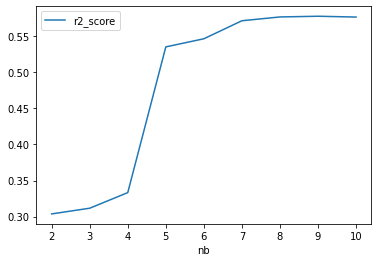

In [86]:
## Feature Selection

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')
import numpy as np

df[TARGET] = df[df[TARGET] > 0][TARGET]
df[TARGET] = np.log(df[TARGET])

df.replace([np.inf, -np.inf], np.nan, inplace=True)
data_for_training = df.dropna()

cols = data_for_training.select_dtypes(include=["object"]).columns.tolist()
data_for_training[cols] = data_for_training[cols].apply(LabelEncoder().fit_transform)

data_for_training = pd.DataFrame(StandardScaler().fit_transform(data_for_training), columns=data_for_training.columns)


y = data_for_training[TARGET]
df_pca = data_for_training.drop(columns=[TARGET]).copy()
X = df_pca.values
cols = df_pca.columns

scores = []
pipelines = []
for nb_features in range(2, 11):
    select = SelectKBest(score_func=f_regression, k=nb_features)
    selection = select.fit_transform(X, y)

    # Init, fit
    X_train, X_test, y_train, y_test = train_test_split(selection, y, random_state=42)
    model = RandomForestRegressor().fit(X_train, y_train)

    y_pred = model.predict(X_test)
    scores.append({'nb': nb_features, 'r2_score': r2_score(y_test, y_pred)})
    pipelines.append({'nb' : nb_features, 'model' : model, 'select': select})
    
r2_scores = pd.DataFrame(scores)

r2_scores.plot.line(x='nb', y='r2_score');

In [87]:
best_nb = r2_scores[r2_scores['r2_score'] == r2_scores['r2_score'].max()].index.values.astype(int)[0]
best_model = pipelines[best_nb]['model']
best_select = pipelines[best_nb]['select']

mask = best_select.get_support()

names = cols[mask]
scores = best_select.scores_[mask]


best_features = pd.DataFrame(list(zip(cols[mask], scores)), columns=['feature', 'f_score'])

best_features.to_csv('./../docs/best_features_selection.csv', index=False)

best_features.sort_values(['f_score', 'feature'], ascending = [False, True])

,feature,f_score
3,largest_property_use_type_gfa,422.777655
2,property_gfa_building,381.361750
1,property_gfa_total,374.992694
5,surface_per_building,278.242033
8,target_mean,186.563330
7,building_primary_type,183.995445
4,surface_per_floor,67.897276
6,have_parking,49.689878
0,council_district_code,48.944842


In [88]:
print('Done')

Done
